# 实战项目3：实现SLAM 

---

## 项目概述

在这个项目中，你将要在一个2维网格世界中使一个会移动与感测的机器人实现SLAM（实时定位与地图构建）！

当这个机器人进行实时移动和感测时，SLAM为我们提供了一种用于定位机器人并构建其所在环境的地图的一种方法。这是机器人与自动系统领域一个非常活跃的研究领域。由于这种定位和地图构建依赖于地标的视觉感知，因此属于计算机视觉范畴。

接下来，你需要使用之前所学的机器人运动、运动与感测中的不确定性表示以及定位技术，定义一个函数`slam`，它需要接收六个参数作为输入并返回矢量`mu`。
>   `mu`包含机器人移动时的坐标位置（x，y）以及它在该空间感测到的地标位置

你可以根据需要实现几个辅助函数，但是这些函数必须返回`mu`。矢量`mu`应该包含交错的坐标（x，y），例如，如果有2个姿势和2个地标，`mu`将如下所示，其中`P`表示机器人位置，`L`表示地标位置：

In [ ]:
mu =  matrix([[Px0],
              [Py0],
              [Px1],
              [Py1],
              [Lx0],
              [Ly0],
              [Lx1],
              [Ly1]])

你可以看到，`mu`首先会保持这些位置的姿势`(x0, y0), (x1, y1), ...,`......，然后是矩阵末端的地标位置。在里，我们可以把`nx1`矩阵当做是一个向量。

## 创建一个环境

在真实的SLAM问题中，你可能会获得一个包含有关地标位置信息的地图，而在这个示例中，我们将使用`make_data`函数创建自己的数据，该函数会生成一个带有地标的二维空间网格，然后把一个机器人放置在该空间中，并通过其在一些时间步内的移动和感知来生成数据。`make_data`函数依赖于机器人移动与感知函数的正确实现，此时应该已完成实现，并且保存在`robot_class.py` 文件中。实例化的机器人在该世界中移动和感测的过程中，会自动收集数据，而你的SLAM函数需要接收此数据作为输入。因此，我们首先要做的是创建这些数据，然后研究它是如何表示机器人所做的运动和传感器测量。

---

## 创建该世界

使用下面的代码生成一个指定大小的世界，其中的地标位置是随机生成的。你可以更改这些参数，然后观察一下你的SLAM实现会发生怎样的变化吧！

`data`会保存传感器测量值和机器人随时间的运动数据。它会分别将测量值存储为`data[i][0]`，将运动存储为`data[i][1]`。

#### 辅助函数

接下来，你要使用的是`robot`类，这个类看起来是不是和第一个notebook中的类很相似？

实际上，在`helpers.py`文件中，你可以阅读有关如何使用`make_data`函数来创建数据的详细信息。这一点与你在第一个notebook中看到的机器人移动与感测循环部分非常相似。

In [1]:
import numpy as np
from helpers import make_data

# your implementation of slam should work with the following inputs
# feel free to change these input values and see how it responds!

# world parameters
num_landmarks      = 5        # number of landmarks
N                  = 20       # time steps
world_size         = 100.0    # size of world (square)

# robot parameters
measurement_range  = 50.0     # range at which we can sense landmarks
motion_noise       = 2.0      # noise in robot motion
measurement_noise  = 2.0      # noise in the measurements
distance           = 20.0     # distance by which robot (intends to) move each iteratation 


# make_data instantiates a robot, AND generates random landmarks for a given world size and number of landmarks
data = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)

 
Landmarks:  [[86, 11], [46, 88], [67, 59], [78, 58], [49, 6]]
Robot: [x=45.69053 y=96.49583]


### 关于`make_data`的说明

上面的`make_data`函数会接收许多关于世界和机器人的运动与传感器参数，因为它需要完成下列任务：
1. 将机器人实例化 （使用 robot 类）
2. 创建一个包含地标的网格世界

**此函数还会输出地标的真实位置和机器人的 *最终*位置，在测试SLAM的实现时应该参考这些位置。**

返回的`data`是一个数组，其中包含有关**机器人传感器测量**和**机器人运动** `(dx, dy)`的信息，这些信息是在多个时间步`N`内收集的。你*只*需使用这些关于运动和测量的读数来根据时间跟踪这个机器人，然后使用SLAM找到地标确定的位置。我们只需要输出真实的地标位置即可，便于稍后进行比较。


在`data`中，可以从数据组的列中的第一个和第二个索引访问测量与运动数据。有关示例，请参阅以下代码，其中`i`是时间步：

In [2]:
# measurement = data[i][0]
# motion = data[i][1]

In [3]:
# print out some stats about the data
time_step = 0

print('Example measurements: \n', data[time_step][0])
print('\n')
print('Example motion: \n', data[time_step][1])

Example measurements: 
 [[0, -36.7842442552275, 39.35618875432075], [1, 2.4389915859772664, -39.28623478536823], [2, -17.574841137718135, -10.727205157360041], [3, -26.877767420546583, -7.45989413609521], [4, 1.9879471792938657, 42.02843127555288]]


Example motion: 
 [10.21746372398212, 17.193121736587262]


尝试更改`time_step`的值，你应该看到测量值列表会根据机器人移动后看到的世界的不同而不同。在第一个notebook中，我们已经了解到，机器人只能感知到这么远，并且在测量其位置和地标位置之间的距离方面具有一定的准确性。机器人的运动始终是具有两个值的向量：一个是x位移，一个是y位移。在实现SLAM，遍历此数据时，请记住此结构。

## 初始化约束

在这里，最具挑战性的任务是创建和修改约束矩阵与和向量：omega和xi。在第二个notebook中，我们看过一个例子，那个例子说明的是omega和xi如何能够保存所有值，如何定义机器人一维世界中的机器人姿势`xi`和地标位置`Li`之间的关系，如下所示，其中omega是蓝色矩阵，xi是粉色矢量。

<img src='images/motion_constraint.png' width=50% height=50% />


 而在*这个*项目中，你的任务是实现一个二维世界的约束。我们将机器人姿势表示为`Px, Py`，将地标位置表示为`Lx, Ly`。要完成这个任务，这里有一种方法，即在约束矩阵中添加x*和*y位置。

<img src='images/constraints2D.png' width=50% height=50% />

当然了，你也可以选择为每个omega和xi分别创建两个值（一个是x位置，一个是y位置）。

### TODO: 编写一个用于初始化omega和xi的函数

完成函数`initialize_constraints` ，使其返回机器人起始位置的`omega`和`xi`约束。 我们还不知道的任何值都应该用值`0` 来初始化。你可以假设我们的机器人在置信度为100%的情况下从这个世界的中心位置开始出发（此时没有移动或测量噪声）。 通过输入值时间步`N`、`num_landmarks`与`world_size`， 你就可以获得构建正确大小和起始值的初始约束所需的所有信息。

*你可以选择返回一个omega和一个xi，其中包含所有（x，y）位置 *或* 每个中的两个（一个是x值，一个是y），也可以选择你觉得有效的方法。具体怎么选择，由你来决定哦！

In [4]:
def initialize_constraints(N, num_landmarks, world_size):
    ''' This function takes in a number of time steps N, number of landmarks, and a world_size,
        and returns initialized constraint matrices, omega and xi.'''
    
    ## Recommended: Define and store the size (rows/cols) of the constraint matrix in a variable
    
    ## TODO: Define the constraint matrix, Omega, with two initial "strength" values
    ## for the initial x, y location of our robot
    constraints = (N + num_landmarks) * 2
    omega = np.zeros((constraints,constraints))
    omega[0][0] = 1
    omega[1][1] = 1
    #print(omega)
    
    ## TODO: Define the constraint *vector*, xi
    ## you can assume that the robot starts out in the middle of the world with 100% confidence
    
    xi = np.zeros((constraints,1))
    x = world_size / 2.0
    y = world_size / 2.0
    xi[0][0] = x
    xi[1][0] = y
    #print(xi)
    
    return omega, xi
    

### 在创建的过程中进行测试

在创建的过程中进行测试，这个是个好习惯。要说明机器人传感器测量和运动，`slam`需要依赖于创建与更新约束矩阵omega和xi，所以，我们要检查它们是否按预期为所有给定参数初始化。

下面，你会找到一些用于将函数`initialize_constraints`结果可视化的测试代码。在这里，要使用 [seaborn](https://seaborn.pydata.org/) 库进行可视化。

**请更改N、landmarks和world_size的测试值并查看结果**。注意，不要将这些值用作最终的slam函数（译者注：原文是smal，但这里应该是slam）的输入。

此代码会假定你已创建了每个约束`omega` 与 `xi`中的一个值，但你还可以相应地做更改并添加到此代码中。约束的大小应随时间步和地标的数量而变化，因为这些值会影响机器人将使用的姿势数量`(Px0,Py0,...Pxn,Pyn)`和地标位置`(Lx0,Ly0,...Lxn,Lyn)`， 其关系应该在约束矩阵中跟踪。回想一下之前所学的知识，`omega`保存每个变量的权重，而`xi`保存这些变量之和的值，如Notebook 2中所示。你需要使用`world_size`来确定该世界中机器人的起始姿势并填写`xi`的初始值。

In [5]:
# import data viz resources
import matplotlib.pyplot as plt
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

In [6]:
# define a small N and world_size (small for ease of visualization)
N_test = 5
num_landmarks_test = 2
small_world = 10

# initialize the constraints
initial_omega, initial_xi = initialize_constraints(N_test, num_landmarks_test, small_world)

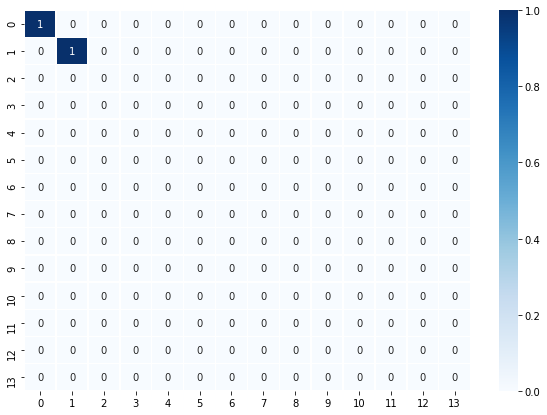

In [7]:
# define figure size
plt.rcParams["figure.figsize"] = (10,7)

# display omega
sns.heatmap(DataFrame(initial_omega), cmap='Blues', annot=True, linewidths=.5)

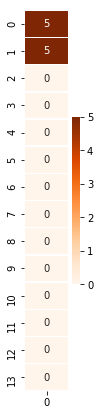

In [8]:
# define  figure size
plt.rcParams["figure.figsize"] = (1,7)

# display xi
sns.heatmap(DataFrame(initial_xi), cmap='Oranges', annot=True, linewidths=.5)

---
## SLAM输入 

除了`data`，SLAM函数还需要接收以下输入：
* N -   机器人将要移动和感测的时间步数
* num_landmarks - 该世界中的地标数量
* world_size - 该世界的大小（宽度 / 高度）
* motion_noise - 与运动相关的噪声；运动的更新置信度应为`1.0/motion_noise`
* measurement_noise - 与测量/感测相关的噪声；测量的更新权重应为`1.0/measurement_noise`

#### 关于噪声的说明

回想一下之前所学的内容，`omega`保存每个位置变量的相对“强度”或权重，你可以通过访问omega `omega[row][col]`中的正确索引并在`noise`为测量值或运动噪声的情况下 *添加/减去*`1.0/noise`来更新这些权重。 `xi`会保存实际的位置值，因此为了更新`xi`，你只需要使用运动或测量的实际值来实现类似的添加过程。因此，对于矢量索引`xi[row][0]`，你最终要做的是添加/减去一个测量或运动值，然后除以它们各自的`noise`。

### TODO: 实现Graph SLAM

按照下面的指示，完成SLAM的实现（我们建议你按照这些TODO的顺序来操作），然后测试实现效果吧！

#### 通过运动和测量进行更新

使用如上所示的2D omega和xi结构（在之前的单元格中），你必须要注意的是如何更新这些约束矩阵中的值才能说明x和y方向上的运动和测量约束。回想一下这些矩阵（包含机器人姿势`P`和地标位置`L`的所有值）的解决方法在于向量`mu`，而`mu`可以在omega和xi构造结束时计算为omega乘以xi的倒数： $\mu = \Omega^{-1}\xi$

**如果想要显示最终状态，你也可以选择返回`omega`和`xi`的值！**

In [9]:
## TODO: Complete the code to implement SLAM

## slam takes in 6 arguments and returns mu, 
## mu is the entire path traversed by a robot (all x,y poses) *and* all landmarks locations
def slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise):
    
    ## TODO: Use your initilization to create constraint matrices, omega and xi
    omega,Xi = initialize_constraints(N, num_landmarks, world_size)
    
    mea_noise = 1.0 / measurement_noise
    mot_noise = 1.0 / motion_noise
    
    ## TODO: Iterate through each time step in the data
    ## get all the motion and measurement data as you iterate
    for t_step,(meauremen,motion) in enumerate(data):
    ## TODO: update the constraint matrix/vector to account for all *measurements*
    ## this should be a series of additions that take into account the measurement noise
        Pxn = t_step * 2      ## 每次 step 时 PXn 的索引
        Pyn = t_step * 2 + 1  ## 每次 step 时 PYn 的索引
        for L_index,dx,dy in meauremen:
            Lxn = 2 * (N + L_index)      ## 地标在 X 的索引
            Lyn = 2 * (N + L_index) + 1  ## 地标在 Y 的索引
            
            #pdb.set_trace()
            # 更新 x 约束条件矩阵
            omega[Pxn][Pxn] += mea_noise
            omega[Lxn][Lxn] += mea_noise
            omega[Pxn][Lxn] += -mea_noise
            omega[Lxn][Pxn] += -mea_noise
            
            Xi[Pxn][0] += -dx / measurement_noise
            Xi[Lxn][0] += dx / measurement_noise 
            
            # 更新 y 约束条件矩阵
            omega[Pyn][Pyn] += mea_noise
            omega[Lyn][Lyn] += mea_noise
            omega[Pyn][Lyn] += -mea_noise
            omega[Lyn][Pyn] += -mea_noise
            
            Xi[Pyn][0] += -dy / measurement_noise
            Xi[Lyn][0] += dy / measurement_noise
            
    ## TODO: update the constraint matrix/vector to account for all *motion* and motion noise
        Pxm = Pxn + 2   ## 移动之后的 x 索引
        Pym = Pyn + 2   ## 移动之后的 y 索引
        #pdb.set_trace()
        # 更新 x 约束条件矩阵
        omega[Pxn][Pxn] += mot_noise
        omega[Pxm][Pxm] += mot_noise
        omega[Pxn][Pxm] += -mot_noise
        omega[Pxm][Pxn] += -mot_noise
        
        Xi[Pxn][0] += -motion[0] / motion_noise
        Xi[Pxm][0] += motion[0] / motion_noise
        
        # 更新 y 约束条件矩阵
        omega[Pyn][Pyn] += mot_noise
        omega[Pym][Pym] += mot_noise
        omega[Pyn][Pym] += -mot_noise
        omega[Pym][Pyn] += -mot_noise
        
        Xi[Pyn][0] += -motion[1] / motion_noise
        Xi[Pym][0] += motion[1] / motion_noise
    
    ## TODO: After iterating through all the data
    ## Compute the best estimate of poses and landmark positions
    ## using the formula, omega_inverse * Xi
    # sns.heatmap(DataFrame(omega), cmap='Blues', annot=True, linewidths=.5)
    # sns.heatmap(DataFrame(Xi), cmap='Oranges', annot=True, linewidths=.5)
    omega_inv = np.linalg.inv(np.matrix(omega))
    mu = omega_inv * Xi
    
    return mu # return `mu`


## 辅助函数

 为了检查你的SLAM实现是否适用于各种输入，我们提供了两个辅助函数，可用于帮助显示函数生成的估计姿势和地标位置。首先，给定一个结果`mu`和时间步`N`，然后，定义一个提取姿势和地标位置的函数，并将它们作为自己的单独列表返回。

最后，定义一个能够很好地输出这些列表的函数。我们将在下一步中调用这两个辅助函数。

In [10]:
# a helper function that creates a list of poses and of landmarks for ease of printing
# this only works for the suggested constraint architecture of interlaced x,y poses
def get_poses_landmarks(mu, N):
    # create a list of poses
    poses = []
    for i in range(N):
        poses.append((mu[2*i].item(), mu[2*i+1].item()))

    # create a list of landmarks
    landmarks = []
    for i in range(num_landmarks):
        landmarks.append((mu[2*(N+i)].item(), mu[2*(N+i)+1].item()))

    # return completed lists
    return poses, landmarks


In [11]:
def print_all(poses, landmarks):
    print('\n')
    print('Estimated Poses:')
    for i in range(len(poses)):
        print('['+', '.join('%.3f'%p for p in poses[i])+']')
    print('\n')
    print('Estimated Landmarks:')
    for i in range(len(landmarks)):
        print('['+', '.join('%.3f'%l for l in landmarks[i])+']')


## 运行SLAM

 `slam` 实现以后，看一看对于不同的空间大小和不同的地标，它会返回什么`mu`值吧！

### 预期的结果是什么

虽然生成的`data`是随机的，但你之前确实需要指定机器人预期移动的数量或时间步`N`以及该二维空间中的`num_landmarks`。而在这个空间中，你实现的`slam`应该能够预测到一个位置，也应该可以从该方形空间的正中心开始估计姿势，而这个方形空间的大小由`world_size`定义。

考虑到这些值，你预期看到的结果应该会显示两个列表：
1. **Estimated poses**： 一个（x，y）对的列表，其长度恰好为`N`，因为这是你的机器人所做的运动次数。第一个姿势应该是该二维空间的中心，对于一个方形大小为100.0的世界，这个坐标是`[50.000, 50.000]`。
2. **Estimated landmarks**： 一个地标位置列表（x，y），其长度恰好是`num_landmarks`。

#### 地标位置

如果在创建此数据时回头查看一下*确切*地标位置的输出数据，你应该会发现那些数据与这些坐标非常相似，但不完全一致，因为`slam`必须考虑运动和测量中的噪声。

In [12]:
# call your implementation of slam, passing in the necessary parameters
mu = slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise)

# print out the resulting landmarks and poses
if(mu is not None):
    # get the lists of poses and landmarks
    # and print them out
    poses, landmarks = get_poses_landmarks(mu, N)
    print_all(poses, landmarks)



Estimated Poses:
[50.000, 50.000]
[44.145, 41.184]
[35.244, 30.509]
[28.102, 20.049]
[28.202, 15.541]
[40.147, 12.843]
[57.615, 14.479]
[69.387, 18.811]
[65.699, 22.291]
[70.055, 26.169]
[59.944, 30.139]
[43.175, 34.578]
[37.375, 37.783]
[45.040, 41.452]
[59.377, 44.066]
[73.244, 43.559]
[71.807, 36.939]
[79.052, 35.630]
[80.444, 31.728]
[95.130, 45.304]


Estimated Landmarks:
[15.513, 91.045]
[54.519, 18.896]
[37.829, 48.725]
[29.414, 49.228]
[51.988, 92.028]


## 将构建的世界可视化

最后一步，要使用的是`helpers.py`文件（该文件在第一个notebook中曾使用过）中的`display_world`代码，我们实际上可以将`slam`编码的内容可视化，该内容包括由运动与测量数据创建的机器人最终位置和地标位置！

**请注意，这些应该与我们在此notebook中之前调用`make_data`时输出的*真实*地标位置和最终姿势非常相似。**

Last pose:  (95.13046693176986, 45.30432557427966)


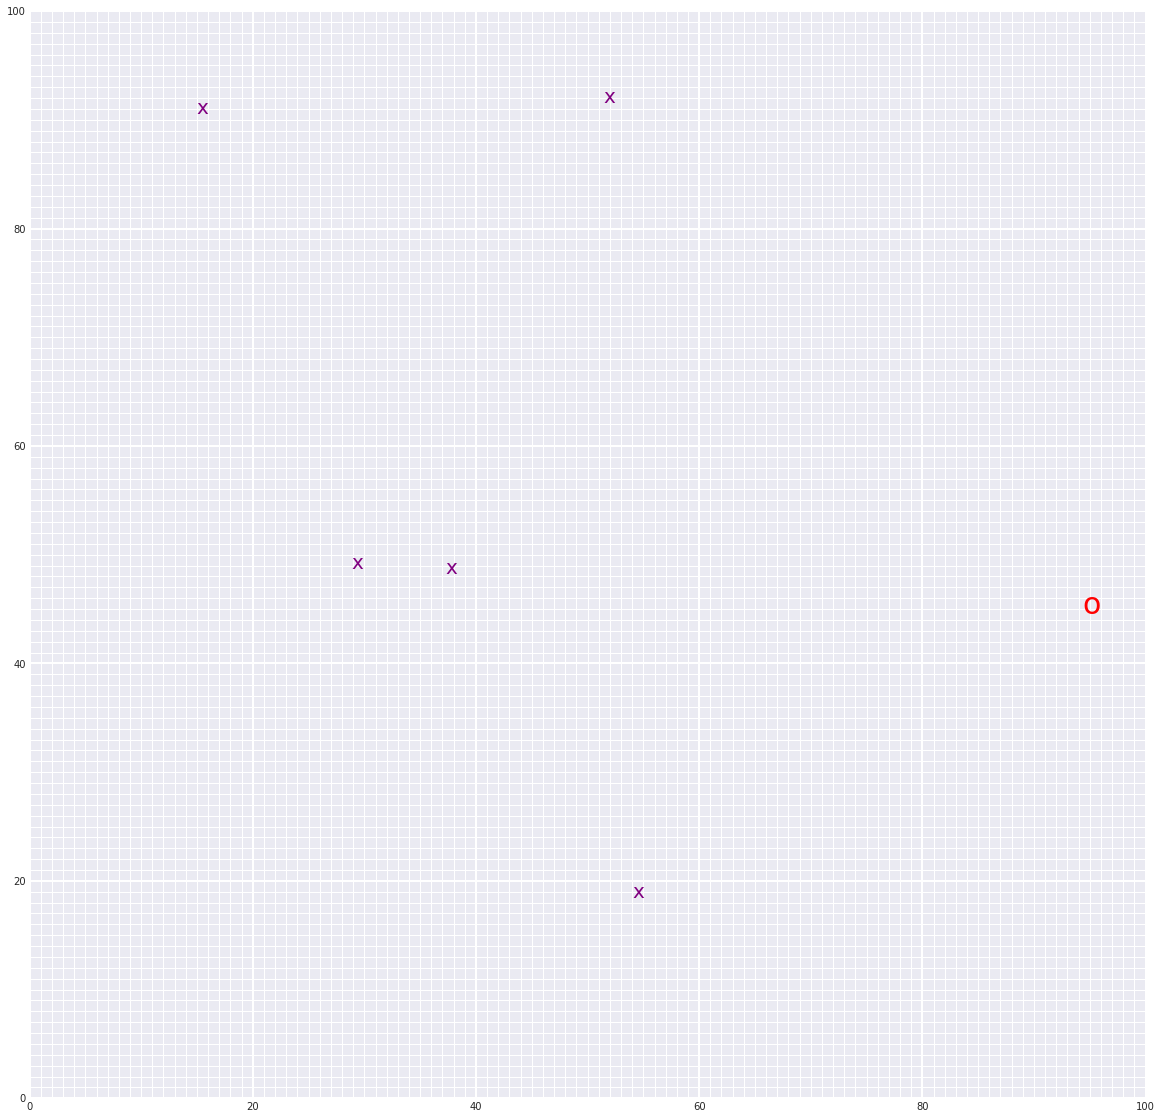

In [13]:
# import the helper function
from helpers import display_world

# Display the final world!

# define figure size
plt.rcParams["figure.figsize"] = (20,20)

# check if poses has been created
if 'poses' in locals():
    # print out the last pose
    print('Last pose: ', poses[-1])
    # display the last position of the robot *and* the landmark positions
    display_world(int(world_size), poses[-1], landmarks)

### 问题：*真实的*的最终姿势，与你根据`slam`预测的最终姿势相距有多远？你认为，为什么会产生这种差异？

你可以在调用`make_data`的第一个单元格中找到最终姿势的真实值。你可能还想查看真实的地标位置，并将它们与`slam`估计的位置进行比较。在这里，请尝试思考一下：如果我们做更多移动（增加N），你认为会发生什么？或者，如果噪声参数更低或更高，会出现什么样的结果？

**答案**: 
对于增加N的值，做了尝试，将N的值修改为15,20,25,30,35,40,45,50,55,60,65,70。然后分别记录最终姿势的真实值和slam估计最终姿势位置，将他们进行比较。我用真实值的 x/y 减去 slam 预测的 x/y 值，将得到得结果通过勾股定理计算出实际距离，然后将结果统计绘制成折线图。

可在notebook的“附（增大N值，对比输出结果）” 查看统计图。

(其他配置不变,只改变N值)

对此得到结论：增大N值，即增加更多的移动次数，在一定程度上可以提高机器人的置信度，但也会伴随着更多的噪声。根据统计图输出的结果，随着N的增加，slam的预测逐渐逼近，达到一定程度之后就会丢失信息。根据图中给出的信息，似乎在50的时候比较好，但这不是唯一，robot每次移动具有不确定性。但根据地标统计图分析，N值的增多，有渐渐趋近平衡趋势，这可能说明N增多的同时，slam预测会比较达到稳定，但不一定是最佳。

对于噪声参数的降低和增加：

motion_noise_list       = (0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0)

measurement_noise_list  = (0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0)

(可在notebook的“附（修改噪声值，增大或减小噪声值）” 查看统计图)

通过一系列的噪声参数设置，然后输出结果。根据统计分析，可得到以下结果：

更高的噪声在slam中会影响到 omega 和 xi 的值。在slam中，采用 1/noise 的方式更新置信度，这意味着高噪声可能会减少slam的置信度，同时也会减少 xi 的值。根据统计图得到的结果，在高噪声的情况下，slam预测结果都比较偏离原信息。同时较低的噪声也会对影响slam的预测。


## 测试

要在提交项目之前确认你的slam代码是有效的，因此，我们建议你通过某些测试数据和示例来尝试运行一下。在下面的单元格中，我们为你提供了一些此类测试用例。准备就绪后，在下一个单元格中取消注释测试用例（这里总共有两个测试用例）。你的输出应该与给定结果**接近或完全相同**。如果存在微小差异，则可能是浮点精度问题或逆矩阵的计算问题。

### 提交项目

如果通过了这些测试，表明你的项目将通过项目审阅标准中的所有要求。按照提交说明正式提交吧！

In [14]:
# Here is the data and estimated outputs for test case 1

test_data1 = [[[[1, 19.457599255548065, 23.8387362100849], [2, -13.195807561967236, 11.708840328458608], [3, -30.0954905279171, 15.387879242505843]], [-12.2607279422326, -15.801093326936487]], [[[2, -0.4659930049620491, 28.088559771215664], [4, -17.866382374890936, -16.384904503932]], [-12.2607279422326, -15.801093326936487]], [[[4, -6.202512900833806, -1.823403210274639]], [-12.2607279422326, -15.801093326936487]], [[[4, 7.412136480918645, 15.388585962142429]], [14.008259661173426, 14.274756084260822]], [[[4, -7.526138813444998, -0.4563942429717849]], [14.008259661173426, 14.274756084260822]], [[[2, -6.299793150150058, 29.047830407717623], [4, -21.93551130411791, -13.21956810989039]], [14.008259661173426, 14.274756084260822]], [[[1, 15.796300959032276, 30.65769689694247], [2, -18.64370821983482, 17.380022987031367]], [14.008259661173426, 14.274756084260822]], [[[1, 0.40311325410337906, 14.169429532679855], [2, -35.069349468466235, 2.4945558982439957]], [14.008259661173426, 14.274756084260822]], [[[1, -16.71340983241936, -2.777000269543834]], [-11.006096015782283, 16.699276945166858]], [[[1, -3.611096830835776, -17.954019226763958]], [-19.693482634035977, 3.488085684573048]], [[[1, 18.398273354362416, -22.705102332550947]], [-19.693482634035977, 3.488085684573048]], [[[2, 2.789312482883833, -39.73720193121324]], [12.849049222879723, -15.326510824972983]], [[[1, 21.26897046581808, -10.121029799040915], [2, -11.917698965880655, -23.17711662602097], [3, -31.81167947898398, -16.7985673023331]], [12.849049222879723, -15.326510824972983]], [[[1, 10.48157743234859, 5.692957082575485], [2, -22.31488473554935, -5.389184118551409], [3, -40.81803984305378, -2.4703329790238118]], [12.849049222879723, -15.326510824972983]], [[[0, 10.591050242096598, -39.2051798967113], [1, -3.5675572049297553, 22.849456408289125], [2, -38.39251065320351, 7.288990306029511]], [12.849049222879723, -15.326510824972983]], [[[0, -3.6225556479370766, -25.58006865235512]], [-7.8874682868419965, -18.379005523261092]], [[[0, 1.9784503557879374, -6.5025974151499]], [-7.8874682868419965, -18.379005523261092]], [[[0, 10.050665232782423, 11.026385307998742]], [-17.82919359778298, 9.062000642947142]], [[[0, 26.526838150174818, -0.22563393232425621], [4, -33.70303936886652, 2.880339841013677]], [-17.82919359778298, 9.062000642947142]]]

##  Test Case 1
##
# Estimated Pose(s):
#     [50.000, 50.000]
#     [37.858, 33.921]
#     [25.905, 18.268]
#     [13.524, 2.224]
#     [27.912, 16.886]
#     [42.250, 30.994]
#     [55.992, 44.886]
#     [70.749, 59.867]
#     [85.371, 75.230]
#     [73.831, 92.354]
#     [53.406, 96.465]
#     [34.370, 100.134]
#     [48.346, 83.952]
#     [60.494, 68.338]
#     [73.648, 53.082]
#     [86.733, 38.197]
#     [79.983, 20.324]
#     [72.515, 2.837]
#     [54.993, 13.221]
#     [37.164, 22.283]


# Estimated Landmarks:
#     [82.679, 13.435]
#     [70.417, 74.203]
#     [36.688, 61.431]
#     [18.705, 66.136]
#     [20.437, 16.983]


### Uncomment the following three lines for test case 1 and compare the output to the values above ###

mu_1 = slam(test_data1, 20, 5, 100.0, 2.0, 2.0)
poses, landmarks = get_poses_landmarks(mu_1, 20)
print_all(poses, landmarks)



Estimated Poses:
[50.000, 50.000]
[37.973, 33.652]
[26.185, 18.155]
[13.745, 2.116]
[28.097, 16.783]
[42.384, 30.902]
[55.831, 44.497]
[70.857, 59.699]
[85.697, 75.543]
[74.011, 92.434]
[53.544, 96.454]
[34.525, 100.080]
[48.623, 83.953]
[60.197, 68.107]
[73.778, 52.935]
[87.132, 38.538]
[80.303, 20.508]
[72.798, 2.945]
[55.245, 13.255]
[37.416, 22.317]


Estimated Landmarks:
[82.956, 13.539]
[70.495, 74.141]
[36.740, 61.281]
[18.698, 66.060]
[20.635, 16.875]


In [15]:
# Here is the data and estimated outputs for test case 2

test_data2 = [[[[0, 26.543274387283322, -6.262538160312672], [3, 9.937396825799755, -9.128540360867689]], [18.92765331253674, -6.460955043986683]], [[[0, 7.706544739722961, -3.758467215445748], [1, 17.03954411948937, 31.705489938553438], [3, -11.61731288777497, -6.64964096716416]], [18.92765331253674, -6.460955043986683]], [[[0, -12.35130507136378, 2.585119104239249], [1, -2.563534536165313, 38.22159657838369], [3, -26.961236804740935, -0.4802312626141525]], [-11.167066095509824, 16.592065417497455]], [[[0, 1.4138633151721272, -13.912454837810632], [1, 8.087721200818589, 20.51845934354381], [3, -17.091723454402302, -16.521500551709707], [4, -7.414211721400232, 38.09191602674439]], [-11.167066095509824, 16.592065417497455]], [[[0, 12.886743222179561, -28.703968411636318], [1, 21.660953298391387, 3.4912891084614914], [3, -6.401401414569506, -32.321583037341625], [4, 5.034079343639034, 23.102207946092893]], [-11.167066095509824, 16.592065417497455]], [[[1, 31.126317672358578, -10.036784369535214], [2, -38.70878528420893, 7.4987265861424595], [4, 17.977218575473767, 6.150889254289742]], [-6.595520680493778, -18.88118393939265]], [[[1, 41.82460922922086, 7.847527392202475], [3, 15.711709540417502, -30.34633659912818]], [-6.595520680493778, -18.88118393939265]], [[[0, 40.18454208294434, -6.710999804403755], [3, 23.019508919299156, -10.12110867290604]], [-6.595520680493778, -18.88118393939265]], [[[3, 27.18579315312821, 8.067219022708391]], [-6.595520680493778, -18.88118393939265]], [[], [11.492663265706092, 16.36822198838621]], [[[3, 24.57154567653098, 13.461499960708197]], [11.492663265706092, 16.36822198838621]], [[[0, 31.61945290413707, 0.4272295085799329], [3, 16.97392299158991, -5.274596836133088]], [11.492663265706092, 16.36822198838621]], [[[0, 22.407381798735177, -18.03500068379259], [1, 29.642444125196995, 17.3794951934614], [3, 4.7969752441371645, -21.07505361639969], [4, 14.726069092569372, 32.75999422300078]], [11.492663265706092, 16.36822198838621]], [[[0, 10.705527984670137, -34.589764174299596], [1, 18.58772336795603, -0.20109708164787765], [3, -4.839806195049413, -39.92208742305105], [4, 4.18824810165454, 14.146847823548889]], [11.492663265706092, 16.36822198838621]], [[[1, 5.878492140223764, -19.955352450942357], [4, -7.059505455306587, -0.9740849280550585]], [19.628527845173146, 3.83678180657467]], [[[1, -11.150789592446378, -22.736641053247872], [4, -28.832815721158255, -3.9462962046291388]], [-19.841703647091965, 2.5113335861604362]], [[[1, 8.64427397916182, -20.286336970889053], [4, -5.036917727942285, -6.311739993868336]], [-5.946642674882207, -19.09548221169787]], [[[0, 7.151866679283043, -39.56103232616369], [1, 16.01535401373368, -3.780995345194027], [4, -3.04801331832137, 13.697362774960865]], [-5.946642674882207, -19.09548221169787]], [[[0, 12.872879480504395, -19.707592098123207], [1, 22.236710716903136, 16.331770792606406], [3, -4.841206109583004, -21.24604435851242], [4, 4.27111163223552, 32.25309748614184]], [-5.946642674882207, -19.09548221169787]]] 


##  Test Case 2
##
# Estimated Pose(s):
#     [50.000, 50.000]
#     [69.035, 45.061]
#     [87.655, 38.971]
#     [76.084, 55.541]
#     [64.283, 71.684]
#     [52.396, 87.887]
#     [44.674, 68.948]
#     [37.532, 49.680]
#     [31.392, 30.893]
#     [24.796, 12.012]
#     [33.641, 26.440]
#     [43.858, 43.560]
#     [54.735, 60.659]
#     [65.884, 77.791]
#     [77.413, 94.554]
#     [96.740, 98.020]
#     [76.149, 99.586]
#     [70.211, 80.580]
#     [64.130, 61.270]
#     [58.183, 42.175]


# Estimated Landmarks:
#     [76.777, 42.415]
#     [85.109, 76.850]
#     [13.687, 95.386]
#     [59.488, 39.149]
#     [69.283, 93.654]


### Uncomment the following three lines for test case 2 and compare to the values above ###

mu_2 = slam(test_data2, 20, 5, 100.0, 2.0, 2.0)
poses, landmarks = get_poses_landmarks(mu_2, 20)
print_all(poses, landmarks)




Estimated Poses:
[50.000, 50.000]
[69.181, 45.665]
[87.743, 39.703]
[76.270, 56.311]
[64.317, 72.176]
[52.257, 88.154]
[44.059, 69.401]
[37.002, 49.918]
[30.924, 30.955]
[23.508, 11.419]
[34.180, 27.133]
[44.155, 43.846]
[54.806, 60.920]
[65.698, 78.546]
[77.468, 95.626]
[96.802, 98.821]
[75.957, 99.971]
[70.200, 81.181]
[64.054, 61.723]
[58.107, 42.628]


Estimated Landmarks:
[76.779, 42.887]
[85.065, 77.438]
[13.548, 95.652]
[59.449, 39.595]
[69.263, 94.240]


## 附（增大N值，对比输出结果）

尝试增大 N 的值，对比输出结果。为了方便查看结果，将 N 的值放到列表中。统一计算返回结果。

（备注：这里我拷贝了一份 helpers.py 的代码，改名为 helpers_test。在 make_data 中加入两个返回结果，即robot最终姿势坐标和相关地标）

In [16]:
# 机器人最终姿势 和 slam 预测的最终姿势进行对比
# 对比的方式是使用 机器最终姿势 x/y 减去 slam 预测的最终姿势 x/y
# 返回对比的结果

def Contrast_robot_poses(robot_poses,lost_poses):
    constrast = [robot_poses[i] - lost_poses[i] for i in range(len(robot_poses))]
    return constrast

In [17]:
# 地标坐标 和 slam 预测的地标进行对比
# 对比的方式是使用原来的地标 x/y 减去 slam 预测的地标 x/y
# 返回对比的结果

def Contrast_landmarks(src_landmarks, slam_landmarks):
    values = []
    for i in range(len(src_landmarks)):
        src_l = src_landmarks[i]
        slam_l = slam_landmarks[i]
        value = [src_l[i] - slam_l[i] for i in range(len(src_l))]
        values.append(value)
    return values

In [18]:
from helpers_test import make_data_test

#修改 N 
N_list = [15,20,25,30,35,40,45,50,55,60,65,70]

data_list = []
for N in N_list:
    data,src_landmarks,robot_poses = make_data_test(N, num_landmarks, world_size, measurement_range, 
                                                    motion_noise, measurement_noise, distance)
    mu = slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise)
    data_list.append([N,robot_poses,src_landmarks,mu])
    print("N = ",N)

 
Landmarks:  [[92, 23], [72, 6], [79, 75], [89, 13], [3, 10]]
Robot: [x=89.17206 y=64.04460]
N =  15
 
Landmarks:  [[69, 53], [95, 90], [28, 54], [96, 79], [44, 76]]
Robot: [x=67.16457 y=96.66194]
N =  20
 
Landmarks:  [[61, 5], [83, 65], [64, 3], [61, 39], [53, 83]]
Robot: [x=90.05694 y=67.18855]
N =  25
 
Landmarks:  [[64, 15], [82, 91], [70, 81], [81, 45], [95, 90]]
Robot: [x=16.19046 y=29.68079]
N =  30
 
Landmarks:  [[43, 33], [59, 41], [58, 63], [69, 88], [3, 9]]
Robot: [x=92.85310 y=53.79674]
N =  35
 
Landmarks:  [[34, 35], [57, 83], [17, 6], [99, 45], [95, 71]]
Robot: [x=51.50202 y=5.20318]
N =  40
 
Landmarks:  [[9, 67], [81, 34], [71, 4], [55, 75], [61, 47]]
Robot: [x=71.84151 y=32.91290]
N =  45
 
Landmarks:  [[67, 12], [44, 5], [48, 48], [31, 73], [73, 59]]
Robot: [x=34.63234 y=61.40977]
N =  50
 
Landmarks:  [[10, 63], [22, 42], [52, 6], [37, 25], [24, 76]]
Robot: [x=44.08436 y=37.51602]
N =  55
 
Landmarks:  [[94, 76], [6, 58], [62, 19], [39, 34], [59, 59]]
Robot: [x=46

In [19]:
robot_contrast = []
landmarks_contrast = []
for N,robot_poses,src_landmarks,mu in data_list:
    if(mu is not None):
        poses, landmarks = get_poses_landmarks(mu, N)
        print("N = ", N)
        
        print("lost poses :")
        print('('+', '.join('%.3f'%l for l in poses[-1])+')')
        
        print("Estimated Landmarks:")
        for i in range(len(landmarks)):
            print('('+', '.join('%.3f'%l for l in landmarks[i])+')')
            
        print("Contrast robot lost poses:")
        r_value = Contrast_robot_poses(robot_poses,poses[-1])
        robot_contrast.append(r_value)
        print('('+', '.join('%.3f'%l for l in r_value)+')')
        
        print("Contrast landmarks:")
        l_value = Contrast_landmarks(src_landmarks,landmarks)
        landmarks_contrast.append(l_value)
        for i in range(len(l_value)):
            print('('+', '.join('%.3f'%l for l in l_value[i])+')')
        
        print('\n')

N =  15
lost poses :
(22.981, 14.022)
Estimated Landmarks:
(16.619, 74.271)
(34.384, 89.063)
(29.721, 26.321)
(17.813, 81.878)
(95.065, 83.734)
Contrast robot lost poses:
(66.191, 50.022)
Contrast landmarks:
(75.381, -51.271)
(37.616, -83.063)
(49.279, 48.679)
(71.187, -68.878)
(-92.065, -73.734)


N =  20
lost poses :
(0.083, 7.259)
Estimated Landmarks:
(37.963, 51.796)
(14.133, 13.602)
(72.946, 49.063)
(12.924, 24.967)
(58.867, 28.846)
Contrast robot lost poses:
(67.082, 89.403)
Contrast landmarks:
(31.037, 1.204)
(80.867, 76.398)
(-44.946, 4.937)
(83.076, 54.033)
(-14.867, 47.154)


N =  25
lost poses :
(8.033, 1.135)
Estimated Landmarks:
(42.318, 86.526)
(21.629, 29.235)
(41.426, 88.623)
(43.832, 53.422)
(47.485, 17.958)
Contrast robot lost poses:
(82.024, 66.054)
Contrast landmarks:
(18.682, -81.526)
(61.371, 35.765)
(22.574, -85.623)
(17.168, -14.422)
(5.515, 65.042)


N =  30
lost poses :
(61.935, -43.085)
Estimated Landmarks:
(28.528, 80.785)
(19.729, 19.327)
(29.200, 28.274)
(

绘制 robot 最终姿势和 slam 预测的最终姿势对比统计图

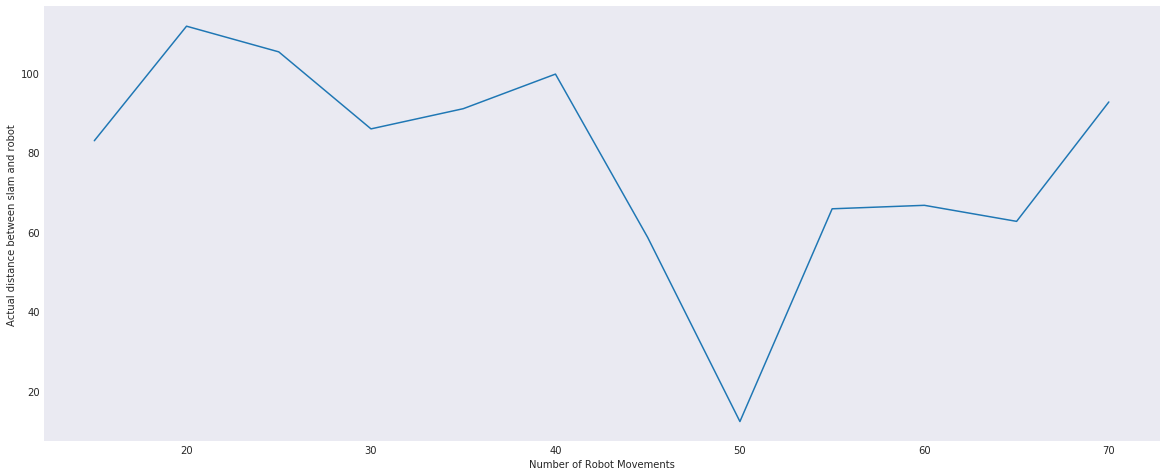

In [20]:
from matplotlib import pyplot as plt

x = np.array([r[0] for r in robot_contrast])
y = np.array([r[1] for r in robot_contrast])
# 根据勾股定理 a**2 + b**2 = z**2
# z 的值即为距离实际地标的值
z = np.sqrt(x**2 + y**2)

fig = plt.figure(figsize=(20,8))
plt.plot(N_list,z)
plt.xlabel("Number of Robot Movements")
plt.ylabel("Actual distance between slam and robot")
plt.show()

绘制原地标与slam预测地标直接距离统计图

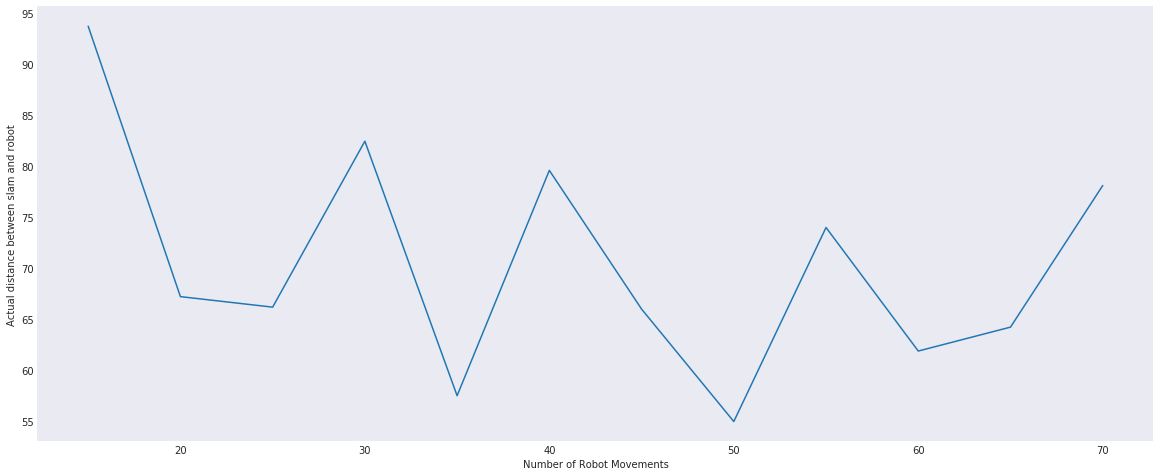

In [21]:
fig = plt.figure(figsize=(20,8))

landmarks_array = np.array(landmarks_contrast)
landmarks_array = landmarks_array.T

z_list = []
for i in range(landmarks_array.shape[1]):
    x = landmarks_array[0][i]
    y = landmarks_array[1][i]
    # 根据勾股定理 a**2 + b**2 = z**2
    # z 的值即为距离实际地标的值
    z = np.sqrt(y**2 + x**2)
    z_list.append(z)

# 对在每个噪声状态下的5个（默认）地标求平均值
z = np.array(z_list)
z = z.sum(axis=0) / num_landmarks

plt.plot(N_list,z)
plt.xlabel("Number of Robot Movements")
plt.ylabel("Actual distance between slam and robot")
plt.show()


## 附（修改噪声值，增大或减小噪声值）


In [22]:
motion_noise_list       = [0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0]      # noise in robot motion
measurement_noise_list  = [0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0]      # noise in the measurements

In [23]:
from helpers_test import make_data_test

N = 20
data_list = []
for i in range(len(motion_noise_list)):
    data,src_landmarks,robot_poses = make_data_test(N, num_landmarks, world_size, measurement_range, 
                                                    motion_noise_list[i], measurement_noise_list[i], distance)
    mu = slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise)
    data_list.append([motion_noise_list[i],measurement_noise_list[i],robot_poses,src_landmarks,mu])
    print("motion_noise = ",motion_noise_list[i])
    print("measurement_noise_list = ",measurement_noise_list[i])

 
Landmarks:  [[5, 94], [81, 14], [1, 66], [10, 39], [11, 92]]
Robot: [x=69.05930 y=83.34321]
motion_noise =  0.5
measurement_noise_list =  0.5
 
Landmarks:  [[38, 61], [93, 6], [82, 43], [72, 84], [19, 68]]
Robot: [x=38.36887 y=33.93880]
motion_noise =  1.0
measurement_noise_list =  1.0
 
Landmarks:  [[94, 79], [30, 74], [59, 9], [65, 23], [63, 92]]
Robot: [x=62.21714 y=46.20295]
motion_noise =  1.5
measurement_noise_list =  1.5
 
Landmarks:  [[28, 38], [46, 22], [51, 56], [38, 74], [48, 68]]
Robot: [x=58.02700 y=55.02777]
motion_noise =  2.0
measurement_noise_list =  2.0
 
Landmarks:  [[28, 81], [32, 13], [81, 38], [46, 95], [73, 8]]
Robot: [x=25.74402 y=15.71428]
motion_noise =  2.5
measurement_noise_list =  2.5
 
Landmarks:  [[66, 13], [91, 55], [31, 39], [81, 90], [100, 91]]
Robot: [x=74.31218 y=69.71339]
motion_noise =  3.0
measurement_noise_list =  3.0
 
Landmarks:  [[90, 30], [40, 42], [82, 28], [31, 87], [5, 80]]
Robot: [x=71.57268 y=24.57207]
motion_noise =  3.5
measurement_n

In [24]:
robot_contrast = []
landmarks_contrast = []
for motion_noise,measurement_noise,robot_poses,src_landmarks,mu in data_list:
    if(mu is not None):
        poses, landmarks = get_poses_landmarks(mu, N)
        print("motion_noise = ", motion_noise)
        print("measurement_noise = ",measurement_noise)
        
        print("lost poses :")
        print('('+', '.join('%.3f'%l for l in poses[-1])+')')
        
        print("Estimated Landmarks:")
        for i in range(len(landmarks)):
            print('('+', '.join('%.3f'%l for l in landmarks[i])+')')
            
        print("Contrast robot lost poses:")
        r_value = Contrast_robot_poses(robot_poses,poses[-1])
        robot_contrast.append(r_value)
        print('('+', '.join('%.3f'%l for l in r_value)+')')
        
        print("Contrast landmarks:")
        l_value = Contrast_landmarks(src_landmarks,landmarks)
        landmarks_contrast.append(l_value)
        for i in range(len(l_value)):
            print('('+', '.join('%.3f'%l for l in l_value[i])+')')
        
        print('\n')

motion_noise =  0.5
measurement_noise =  0.5
lost poses :
(78.886, 4.295)
Estimated Landmarks:
(90.190, 20.105)
(36.806, 61.978)
(94.075, 48.110)
(87.829, 69.734)
(84.739, 21.330)
Contrast robot lost poses:
(-9.827, 79.049)
Contrast landmarks:
(-85.190, 73.895)
(44.194, -47.978)
(-93.075, 17.890)
(-77.829, -30.734)
(-73.739, 70.670)


motion_noise =  1.0
measurement_noise =  1.0
lost poses :
(82.601, 31.062)
Estimated Landmarks:
(51.649, 43.200)
(7.084, 88.982)
(14.475, 55.390)
(22.977, 19.454)
(69.390, 37.183)
Contrast robot lost poses:
(-44.232, 2.876)
Contrast landmarks:
(-13.649, 17.800)
(85.916, -82.982)
(67.525, -12.390)
(49.023, 64.546)
(-50.390, 30.817)


motion_noise =  1.5
measurement_noise =  1.5
lost poses :
(3.540, 69.984)
Estimated Landmarks:
(5.012, 18.559)
(58.569, 27.739)
(35.248, 86.178)
(29.384, 71.803)
(32.067, 13.125)
Contrast robot lost poses:
(58.677, -23.781)
Contrast landmarks:
(88.988, 60.441)
(-28.569, 46.261)
(23.752, -77.178)
(35.616, -48.803)
(30.933, 78.8

绘制 robot 最终姿势和 slam 预测的最终姿势对比统计图

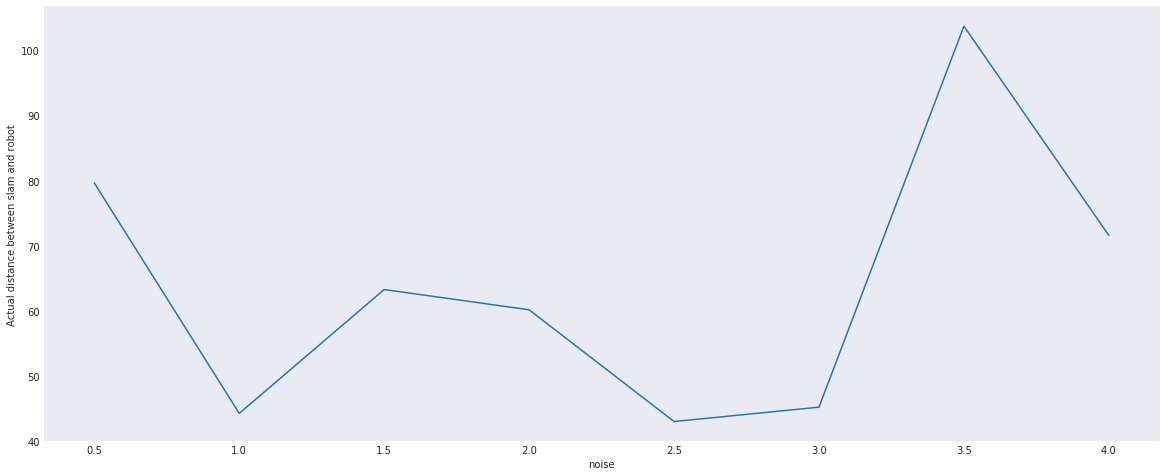

In [25]:
from matplotlib import pyplot as plt

x = np.array([r[0] for r in robot_contrast])
y = np.array([r[1] for r in robot_contrast])
# 根据勾股定理 a**2 + b**2 = z**2
# z 的值即为距离实际地标的值
z = np.sqrt(x**2 + y**2)

fig = plt.figure(figsize=(20,8))
plt.plot(measurement_noise_list,z)
plt.xlabel("noise")
plt.ylabel("Actual distance between slam and robot")
plt.show()

绘制原地标与slam预测地标直接距离统计图

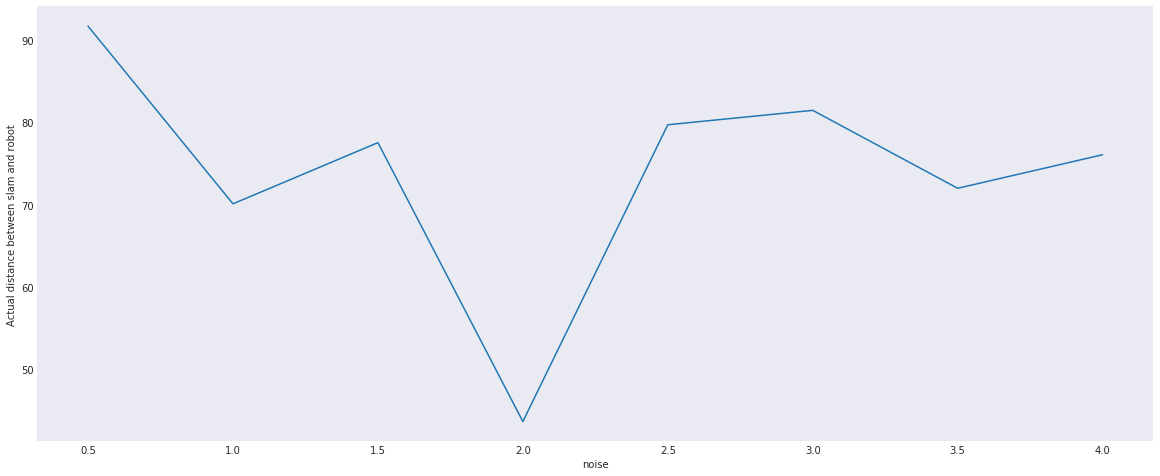

In [26]:
# 
fig = plt.figure(figsize=(20,8))

landmarks_array = np.array(landmarks_contrast)
landmarks_array = landmarks_array.T

z_list = []
for i in range(landmarks_array.shape[1]):
    x = landmarks_array[0][i]
    y = landmarks_array[1][i]
    # 根据勾股定理 a**2 + b**2 = z**2
    # z 的值即为距离实际地标的值
    z = np.sqrt(y**2 + x**2)
    z_list.append(z)

# 对在每个噪声状态下的5个（默认）地标求平均值
z = np.array(z_list)
z = z.sum(axis=0) / num_landmarks

plt.plot(measurement_noise_list,z)
plt.xlabel("noise")
plt.ylabel("Actual distance between slam and robot")
plt.show()